In [1]:
import pandas as pd

# some lines have too many fields (?), so skip bad lines
imgatt = pd.read_csv("CUB_200_2011/attributes/image_attribute_labels.txt",sep='\s+', 
                     header=None, error_bad_lines=False,
                    warn_bad_lines=False, usecols=[0,1,2], 
                     names=['imgid', 'attid', 'present'])

# description from dataset README:
#T he set of attribute labels as perceived by MTukers for each image is contained 
#in the file attributes/image_attribute_labels.txt,
# with each line crresponding to one image/attribute/worker triplet:

# <image_id> <attribute_id> <is_present> <certainty_id> <time>

# where <image_id>, <attribute_id>, <certainty_id> coresspond to the IDs in images.txt, 
# attributes.txt, and attributes/certainties.txt
# respectively. <is_present> is 0 or i (1 denotes that the attribute is present). 
# <time> denotes the time spent by the MTurker is seconds.

In [2]:
imgatt.head()

imgid  attid  present
0      1      1        0
1      1      2        0
2      1      3        0
3      1      4        0
4      1      5        1

In [3]:
imgatt.shape

(3677856, 3)

In [4]:
# Image ID number 1 dose not have attibutes 1,2,3, or 4, but it dose have attribute 5.
# The shpe will tell us how many rows and columns we have.
# It has 3.7 milion rows and three columns. This is not the actual formula that you want. 
# You want attributes to be the columns, not rows.
# need to reorganize imgatt to have one row per imgid, and 312 columns(one column per attribute), 
# with 1/0 in each cell represending
# if that imgid has that attribute or not
imgatt2 = imgatt.pivot(index='imgid', columns='attid', values='present')

In [5]:
imgatt2.head()

attid  1    2    3    4    5    6    7    8    9    10   ...  303  304  305  \
imgid                                                    ...                  
1        0    0    0    0    1    0    0    0    0    0  ...    0    0    0   
2        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
3        0    0    0    0    1    0    0    0    0    0  ...    0    0    0   
4        0    0    0    0    1    0    0    0    0    0  ...    0    0    0   
5        0    0    0    0    1    0    0    0    0    0  ...    0    0    1   

attid  306  307  308  309  310  311  312  
imgid                                     
1        0    0    1    0    0    0    0  
2        0    0    0    0    0    0    0  
3        0    0    1    0    0    1    0  
4        1    0    0    1    0    0    0  
5        0    0    0    0    0    0    0  

[5 rows x 312 columns]

In [6]:
# feed data into a random forest. In the previous example, we have 312 columns and 312 attributes, 
# which is ultimately
# about 12,000 images or 12,000 different examples of birds:
imgatt2.shape

(11788, 312)

In [7]:
# need to load the answers, such as whether it;s a bird and which spcies it is. 
# Since it is an image class labels file, the separators
# are spaces. There is no header row and the two columns are imgid and label. 
# We will be using set_index('imgid') to have the same result
# produced by imgatt2.head(), where the rows are idenfitied by the image ID

# load the image true classes
imglabels = pd.read_csv("CUB_200_2011/image_class_labels.txt", sep=' ', header=None, names=['imgid', 'label'])
imglabels = imglabels.set_index('imgid')

# decription from dataset README:
# The ground truth class labels (bird species labels) for each image are contained 
# in the file image_class_labels.txt,
# with each line corresponding to one image:
# <image_id> <class_id>
# where <image_id> and <class_id> correspond to the IDs in images.txt and classes.txt, respectively

In [8]:
imglabels.head()

label
imgid       
1          1
2          1
3          1
4          1
5          1

In [9]:
imglabels.shape

(11788, 1)

In [10]:
df=imgatt2.join(imglabels)
df=df.sample(frac=1)

In [11]:
df_att=df.iloc[:, :312]
df_label=df.iloc[:, 312:]

In [12]:
df_att.head()

1    2    3    4    5    6    7    8    9    10   ...  303  304  305  \
imgid                                                    ...                  
9426     0    0    0    0    0    0    1    0    0    0  ...    0    1    0   
7056     0    0    0    0    0    0    0    1    0    0  ...    0    0    0   
6321     0    0    0    0    0    0    0    0    0    0  ...    0    0    1   
6359     0    0    0    0    0    0    1    0    0    0  ...    0    0    1   
11409    0    1    0    0    0    0    0    0    0    0  ...    0    0    0   

       306  307  308  309  310  311  312  
imgid                                     
9426     0    0    0    0    0    0    0  
7056     0    0    0    0    1    0    0  
6321     0    0    0    0    0    0    1  
6359     0    0    0    0    0    0    1  
11409    0    0    1    0    0    1    0  

[5 rows x 312 columns]

In [62]:
df_train_att = df_att[:8000]
df_train_label = df_label[:8000]
df_test_att = df_att[8000:]
df_test_label = df_label[8000:]

df_train_label = df_train_label['label']
df_test_label = df_test_label['label']

In [64]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_features=50,random_state=0, n_estimators=100)

In [65]:
clf.fit(df_train_att, df_train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=50, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [66]:
print(clf.predict(df_train_att.head()))

[161 121 108 109 194]


In [67]:
clf.score(df_test_att, df_test_label)

0.4334741288278775

In [68]:
from sklearn.metrics import confusion_matrix
pred_labels = clf.predict(df_test_att)
cm = confusion_matrix(df_test_label, pred_labels)

In [69]:
cm

array([[ 6,  0,  1, ...,  0,  0,  0],
       [ 1, 13,  0, ...,  0,  0,  0],
       [ 3,  0,  4, ...,  0,  0,  0],
       ...,
       [ 0,  0,  1, ...,  4,  0,  0],
       [ 0,  0,  0, ...,  0, 11,  0],
       [ 0,  0,  0, ...,  0,  0, 14]], dtype=int64)

In [76]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion_matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [77]:
birds = pd.read_csv("CUB_200_2011/classes.txt",
                   sep='\s+', header=None, usecols=[1], names=['birdname'])
birds = birds['birdname']
birds

0      001.Black_footed_Albatross
1            002.Laysan_Albatross
2             003.Sooty_Albatross
3           004.Groove_billed_Ani
4              005.Crested_Auklet
                  ...            
195                196.House_Wren
196                197.Marsh_Wren
197                 198.Rock_Wren
198               199.Winter_Wren
199       200.Common_Yellowthroat
Name: birdname, Length: 200, dtype: object

In [78]:
import numpy as np
np.set_printoptions(precision=2)
plt.figure(figsize=(60,60), dpi=300)
plot_confusion_matrix(cm, classes=birds, normalize=True)
plt.show()

Normalized confusion matrix
[[0.4  0.   0.07 ... 0.   0.   0.  ]
 [0.04 0.5  0.   ... 0.   0.   0.  ]
 [0.19 0.   0.25 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.06 ... 0.25 0.   0.  ]
 [0.   0.   0.   ... 0.   0.5  0.  ]
 [0.   0.   0.   ... 0.   0.   0.82]]


In [79]:
from sklearn import tree
clftree = tree.DecisionTreeClassifier()
clftree.fit(df_train_att, df_train_label)
clftree.score(df_test_att, df_test_label)

0.26689545934530096

In [84]:
from sklearn import svm
clfsvm = svm.SVC(gamma='auto')
clfsvm.fit(df_train_att, df_train_label)
clfsvm.score(df_test_att, df_test_label)

0.29197465681098206

In [86]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, df_train_att, df_train_label, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))

Accuracy: 0.44 (+/- 0.01)


In [88]:
scorestree = cross_val_score(clftree, df_train_att, df_train_label, cv=5)
print("Accuracy: %0.2f (+/-%0.2f)" % (scorestree.mean(), scores.std()*2))

Accuracy: 0.25 (+/-0.01)


In [89]:
scoressvm = cross_val_score(clfsvm, df_train_att, df_train_label, cv=5)
print("Accuracy: %0.2f (+/-%0.2f)" % (scoressvm.mean(), scoressvm.std()*2))

Accuracy: 0.27 (+/-0.00)


In [91]:
max_features_opts = range(5,50,5)
n_estimators_opts = range(10,200,20)
rf_params = np.empty((len(max_features_opts)*len(n_estimators_opts),4),float)
i=0
for max_features in max_features_opts:
    for n_estimators in n_estimators_opts:
        clf = RandomForestClassifier(max_features=max_features, n_estimators=n_estimators)
        scores = cross_val_score(clf, df_train_att, df_train_label, cv=5)
        rf_params[1,0] = max_features
        rf_params[i,1] = n_estimators
        rf_params[i,2] = scores.mean()
        rf_params[i,3] = scores.std()*2
        i+=1
        print("Max featues: %d, num estimators: %d, accuracy: %0.2f (+/- %0.2f)" % \
             (max_features, n_estimators, scores.mean(), scores.std()*2))

Max featues: 5, num estimators: 10, accuracy: 0.27 (+/- 0.02)
Max featues: 5, num estimators: 30, accuracy: 0.35 (+/- 0.02)
Max featues: 5, num estimators: 50, accuracy: 0.39 (+/- 0.01)
Max featues: 5, num estimators: 70, accuracy: 0.41 (+/- 0.01)
Max featues: 5, num estimators: 90, accuracy: 0.42 (+/- 0.01)
Max featues: 5, num estimators: 110, accuracy: 0.43 (+/- 0.01)
Max featues: 5, num estimators: 130, accuracy: 0.44 (+/- 0.01)
Max featues: 5, num estimators: 150, accuracy: 0.44 (+/- 0.01)
Max featues: 5, num estimators: 170, accuracy: 0.44 (+/- 0.02)
Max featues: 5, num estimators: 190, accuracy: 0.45 (+/- 0.01)
Max featues: 10, num estimators: 10, accuracy: 0.29 (+/- 0.03)
Max featues: 10, num estimators: 30, accuracy: 0.38 (+/- 0.02)
Max featues: 10, num estimators: 50, accuracy: 0.41 (+/- 0.01)
Max featues: 10, num estimators: 70, accuracy: 0.42 (+/- 0.01)
Max featues: 10, num estimators: 90, accuracy: 0.43 (+/- 0.01)
Max featues: 10, num estimators: 110, accuracy: 0.45 (+/- 0.

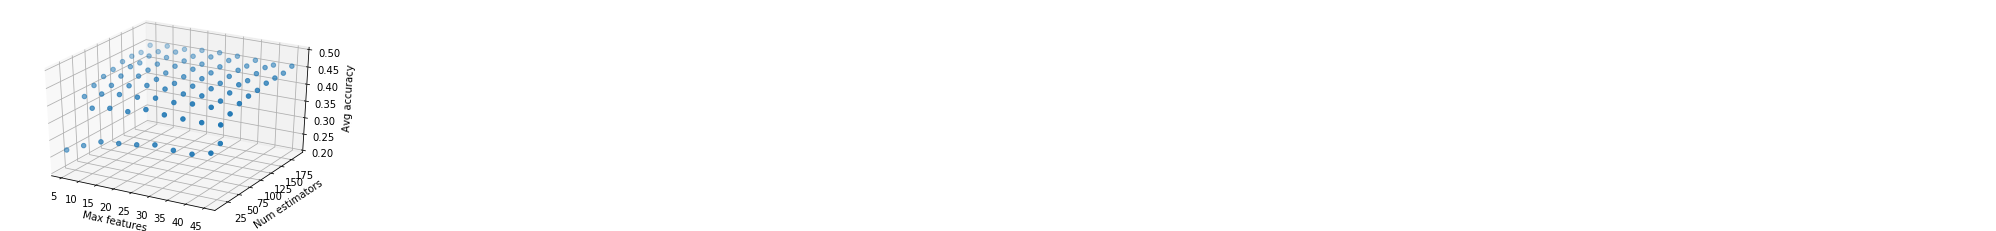

In [94]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
fig.clf()
ax = fig.gca(projection='3d')
x = rf_params[:,0]
y = rf_params[:,1]
z = rf_params[:,2]
ax.scatter(x,y,z)
ax.set_zlim(0.2, 0.5)
ax.set_xlabel('Max features')
ax.set_ylabel('Num estimators')
ax.set_zlabel('Avg accuracy')
plt.show()